# Import dependancies

In [1]:
import os, re
import pandas as pd
from summarise.io import doc_to_csv
from summarise.io import pdf_to_text_file

# Fetch raw data

In [2]:
# Define constants
ROOT        = os.path.abspath('') #current directory
DATA_FOLDER = os.path.join( ROOT, 'data')
ALL_DATA    = os.path.join( DATA_FOLDER, 'all_data.csv' )
if os.path.isfile( ALL_DATA ):
    # Read pre-processed data
    df          = pd.read_csv( ALL_DATA )
else:
    # Create from scratch
    filenames   = pdf_to_text_file( DATA_FOLDER )
    df          = doc_to_csv( filenames, ALL_DATA )

# Initial Processing

In [3]:
df.head()

,Unnamed: 0,Name,Text
0,0,cyborg-supervision-speech-by-james-proudman.txt,\r\n\r\n \r\n \r\n \r\n \r\n \r\n \r\n \r\n \...
1,1,managing-machines-the-governance-of-artificial...,\r\n\r\n \r\n \r\n \r\n \r\n \r\n \r\n \r\n \...
2,2,supervisor-centred-automation-the-role-of-huma...,\r\n\r\n \r\n \r\n \r\n \r\n \r\n \r\n \r\n \...


# Helper Functions

In [4]:
# Regular expression helpers
def find_url(string): 
    text = re.findall('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+',string)
    return "".join(text) # converting return value from list to string

def find_email(text):
    line = re.findall(r'[\w\.-]+@[\w\.-]+',str(text))
    return ",".join(line)

def remove_whitespace( text ):
    # Replace blank lines with newline characters
    text = re.sub( r'\n[ \t\r\f\v]+', '\n', text )
    # Replace repeated newline charactes with single new line
    text = re.sub( r'[\n\r]+', '\n', text )
    # Replace repeated non-newline characters
    text = re.sub( r'(?:(?![\n\r])\s)+', ' ', text )
    return text


In [5]:
# Initialise pipeline
import spacy
nlp = spacy.load("en_core_web_sm")
# NOTE: Dependancy: python -m spacy download en_core_web_sm

In [6]:
text = df['Text'].values.tolist()
text = [ remove_whitespace(item) for item in text ]
docs = list( nlp.pipe(text) )
print(nlp.pipe_names)

['tagger', 'parser', 'ner']


In [7]:
doc = nlp(text[0])

In [8]:
from spacy import displacy
displacy.render(doc, style="ent")

# Visualisation

In [9]:
#Generate clean list of tokens for wordcloud
tokens = []
for word in doc:
    if word.is_alpha and not( word.is_stop ):
        tokens.append( word.lemma_.lower() )

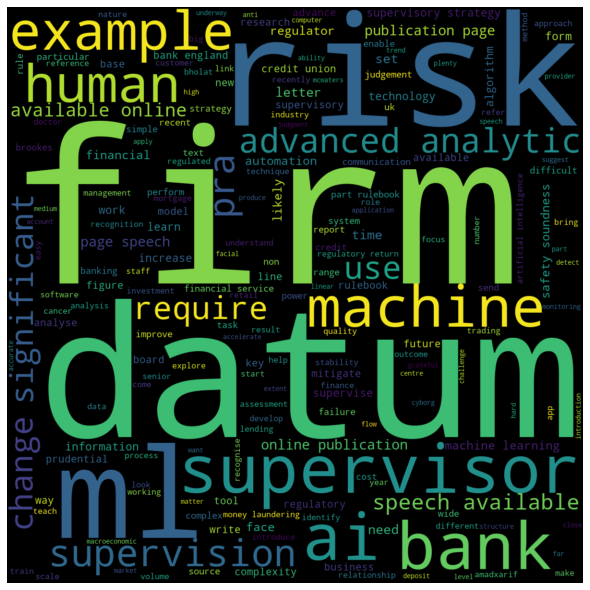

In [10]:
# Create wordcloud
from wordcloud import WordCloud, ImageColorGenerator
import numpy as np
import matplotlib.pyplot as plt 
from PIL import Image
clean_text = ""
clean_text += " ".join(tokens)+" "

mask = np.array(Image.open("img/boe.png"))
image_colors = ImageColorGenerator(mask)

wordcloud = WordCloud(width = 1200, height = 1200, 
                background_color = 'black',  
                #mask=mask,              
                min_font_size = 10).generate(clean_text)
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud, interpolation="bilinear") 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 
# store to file
# plt.savefig("img/wordcloud.png", format="png")

In [11]:
# Histogram of words
token_df = pd.DataFrame( tokens, columns=['Tokens'] )
# Count of appearances of each word
token_count_df = token_df.groupby( 'Tokens' ).size()\
                                        .reset_index( name='Counts' )\
                                        .sort_values( 'Counts', ascending=False )\
                                        .reset_index( drop=True )
token_count_df.head(15)

,Tokens,Counts
0,firm,38
1,datum,27
2,risk,25
3,available,23
4,machine,21
5,speech,20
6,bank,19
7,ml,16
8,supervisor,15
9,ai,14


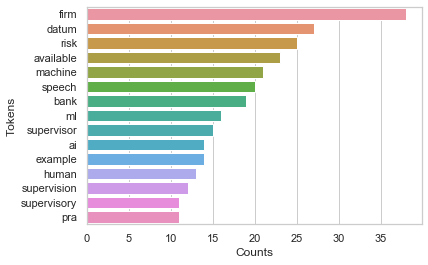

In [12]:
#Plot histogram
import seaborn as sns
sns.set(style="whitegrid")
sns.barplot(x="Counts", y="Tokens", data=token_count_df.head(15))

# Pipeline

In [13]:
# Import sklearn classes
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline
# Import spacy
import spacy

In [14]:
# Custom class for cleaning data
class cleaner(TransformerMixin):
    def transform(self, X, **transform_params):
        # Cleaning Text
        return [remove_whitespace(text) for text in X]

    def fit(self, X, y=None, **fit_params):
        return self

    def get_params(self, deep=True):
        return {}

    def remove_whitespace( text ):
        # Replace blank lines with newline characters
        text = re.sub( r'\n[ \t\r\f\v]+', '\n', text )
        # Replace repeated newline charactes with single new line
        text = re.sub( r'[\n\r]+', '\n', text )
        # Replace repeated non-newline characters
        text = re.sub( r'(?:(?![\n\r])\s)+', ' ', text )
        return text

# Use spacy to tokenise documents
def tokeniser( document, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'] ):
    """Returns list of tokens from document"""    
    nlp = spacy.load("en_core_web_sm")
    doc = nlp(document)
    #Generate clean list of tokens
    tokens = []
    for word in doc:
        if word.is_alpha and not( word.is_stop ) and \
            word.pos_ in allowed_postags:
            tokens.append( word.lemma_.lower() ) 
    return tokens

# Feature engineering
bow_vector      = CountVectorizer( 
                        tokenizer = tokeniser,
                        token_pattern='[a-zA-Z0-9]{3,}', # num chars > 3                       
                        ngram_range=(1,1) #only consider unigrams
                        ) 
#tfidf_vector    = TfidfVectorizer(tokenizer = tokeniser)

In [15]:
# Load the LDA model from sk-learn
from sklearn.decomposition import LatentDirichletAllocation as LDA

# Tweak the two parameters below
number_topics = 3
number_words = 10 
# Create LDA model
lda = LDA( 
        n_components = number_topics, 
        n_jobs=-1, 
        random_state=42
        )

# Create pipeline using Bag of Words
pipe = Pipeline([('cleaner', cleaner()),
                 ('vectoriser', bow_vector),
                 ('reduce_dim', lda)])
# Fit model
X = df['Text'].values.tolist()
pipe.fit(X)

Pipeline(memory=None,
         steps=[('cleaner', <__main__.cleaner object at 0x000001F5A8D60A08>),
                ('vectoriser',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,...
                                 vocabulary=None)),
                ('reduce_dim',
                 LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                                           evaluate_every=-1,
                                           learning_decay=0.7,
                                           learning_method='batch',
                           

In [16]:
# Helper function
def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
# Print the topics found by the LDA model
print("Topics found via LDA:")
print_topics(pipe[2], pipe[1], number_words)

Topics found via LDA:

Topic #0:
technology datum firm supervision speech rule way supervisor prudential time

Topic #1:
firm datum risk machine speech available human financial example bank

Topic #2:
publish show equity subject assumption attach cultural conference eliminate reform


In [17]:
# Optimise hyper parameters
from sklearn.model_selection import GridSearchCV
# Define Search Param
#search_params = {'reduce_dim__n_components': [3, 5, 10], 'reduce_dim__learning_decay': [.5, .7, .9], 'reduce_dim__doc_topic_prior': [.01, .1, .3], 'reduce_dim__topic_word_prior': [.01, .1, .3]}
search_params = {'reduce_dim__learning_decay': [.5, .7, .9], 'reduce_dim__doc_topic_prior': [.01, .1, .3], 'reduce_dim__topic_word_prior': [.01, .1, .3]}
# Init the Model
search = GridSearchCV( pipe, param_grid = search_params, cv=3, n_jobs=-1 )
#search.estimator.get_params().keys()

In [18]:
# Do the Grid Search
#search.fit(X)

In [19]:
#search.best_params_

NameError: name 'text' is not defined